In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm_notebook
from scipy.stats import norm, poisson, gamma, uniform
sns.set(style="white")

正規分布の母数を推定する。ただし、事前分布は(0, 1000)の一様分布とする。

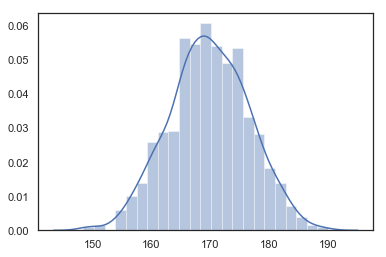

In [6]:
mu_true = 170
sigma_true = 7
n_sample = 1000

prior_min = 0
prior_max = 1000

np.random.seed(7)
data = norm.rvs(mu_true, sigma_true, n_sample)
sns.distplot(data)

In [7]:
prior = uniform(prior_min, prior_max)

ハミルトニアンは位置エネルギーと運動エネルギーの和である。理想状態では物体はハミルトニアンが一定になるように運動する。ハミルトニアンが保存されることを用いて、物体の運動の軌跡を予測することができる。  

ハミルトニアンを微分し。0と置くことでハミルトンの運動方程式を得る。これをleap frog法により解くことで、奇跡が予測できる。運動量と位置を交互に更新していくことで、ハミルトニアンを高い精度で保存する方法。  

質量m=1、重力加速度g=1とすると、位置エネルギーはhで表される。HMC法では、hはパラメータ$\theta$の関数であり、マイナスをとった対数事後分布を表す。つまり、事後確率が高いところは高さが低いところに相当し、物体が通ることが多くなる。また、運動エネルギーは$\frac{1}{2m}p^2$である。pは標準正規分布からのサンプルである。  

事後分布と標準正規分布の同時分布のカーネルがハミルトニアンになる。このとき、新しい候補の受容確率はハミルトニアンの差の指数となり、ハミルトニアンの差は近似誤差のみで、0に近い値をとるので、受容確率は1に近くなる。

In [46]:
# x[0]: mu, x[1]: sigma
def log_posterior_kernel(x, mu, sigma):
    return n_sample * np.log(sigma ** 2) / 2 + np.square(x - mu).sum() / (2 * sigma ** 2)

# それぞれのパラメータによる微分を並べる
def log_posterior_kernel_diff(x, mu, sigma):
    dmu = -(x - mu).sum() / sigma ** 2
    dsigma = n_sample / (2 * sigma ** 2) - np.square(x - mu).sum() / (2 * sigma ** 4)
    return np.array([dmu, dsigma])

In [82]:
import sympy
from sympy import symbols

n, x, mu, sig = symbols('x y mu sig' )
n * sympy.log(sig ** 2)  / 2 

x*log(sig**2)/2

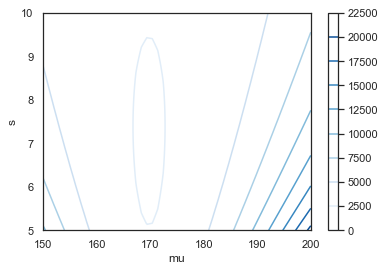

In [50]:
# パラメータと対数事後確率のカーネルの　contour plot
# vectorizeするのは難しそう。。
x1 = np.linspace(150, 200)
x2 = np.linspace(5, 10)
X1, X2 = np.meshgrid(x1, x2)
Z = np.array([log_posterior_kernel(data, a, b) for a, b in zip(X1.flatten(), X2.flatten())])
Z = Z.reshape(X1.shape)

plt.contour(X1, X2, Z, cmap=cm.Blues)
plt.xlabel("mu")
plt.ylabel("s")
plt.colorbar()

In [51]:
np.random.randn(2)

array([-0.37088578,  0.16181131])

In [22]:
t = 1000
l = 100
eps = 0.01

# initial parameter
current_params = [150, 5]

# generate random variables from standard normal
p = np.random.randn(2)

# leap frog


# accept the proposal or not


res = []
for _  in range(T):
    accepted = False
    p = np.random.randn()
    theta_prop, p_prop = leap_frog_step(theta, p, L, eps)
    r = np.exp(hamiltonian(theta, p) - hamiltonian(theta_prop, p_prop))
#     print(r)
    if np.random.rand() < r:
        accepted = True
        theta= theta_prop
        p = p_prop
    res.append([theta_prop, p_prop, accepted])

NameError: name 'T' is not defined

In [52]:
p = np.random.randn(2)
theta = [150, 5]
p -= eps * log_posterior_kernel_diff(data , theta[0], theta[1]) / 2
theta += eps * p
p -= eps * log_posterior_kernel_diff(data , theta[0], theta[1]) / 2

In [58]:
log_posterior_kernel(data,  theta[0], theta[1]) + (p**2).sum() / 2

14768.320956095447

In [60]:
def hamiltonian(theta, p):
    return log_posterior_kernel(data,  theta[0], theta[1]) + (p**2).sum() / 2

def leap_frog(theta, p, L, eps):
    """
    x: parameter
    y: p
    """
    res = [[theta, p, hamiltonian(theta, p)]]
    for _ in range(L):
        p -= eps * log_posterior_kernel_diff(data , theta[0], theta[1]) / 2
        theta += eps * p
        p -= eps * log_posterior_kernel_diff(data , theta[0], theta[1]) / 2
        res.append([theta, p, hamiltonian(theta, p)])
    return res



# res = []
# for _  in range(T):
#     accepted = False
#     p = np.random.randn()
#     theta_prop, p_prop = leap_frog_step(theta, p, L, eps)
#     r = np.exp(hamiltonian(theta, p) - hamiltonian(theta_prop, p_prop))
# #     print(r)
#     if np.random.rand() < r:
#         accepted = True
#         theta= theta_prop
#         p = p_prop
#     res.append([theta_prop, p_prop, accepted])

In [65]:
p = np.random.randn(2)
theta = [150, 5]
res = leap_frog(theta, p, 100, 0.01)

In [66]:
res

[[[150, 5], array([45.78211507, 25.11116066]), 10359.26546501995],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  10342.784129513393],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  10231.562578343654],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  10038.746105992966],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  9784.734228510415],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  9492.861200732805],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  9185.407388982954],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  8880.913235514561],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  8593.01347049296],
 [array([220.41219201,  28.21704146]),
  array([45.78211507, 25.11116066]),
  8330.474244009012],
 [array([220.41219201,  28.21704146]),
  array([4